<a href="https://colab.research.google.com/github/Roudranil/Bayesian-analysis-of-efficacy-of-the-ChAdOx1-nCoV-19-AZD1222-vaccine/blob/main/dissertation_project_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LaTeX

In [ ]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  lib

In [ ]:
!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal pfb2t1c2pfb
The following NEW packages will be installed:
  cm-super cm-super-minimal pfb2t1c2pfb
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 24.5 MB of archives.
After this operation, 59.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 cm-super-minimal all 0.3.4-11 [5,810 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 pfb2t1c2pfb amd64 0.3-11 [9,342 B]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 cm-super all 0.3.4-11 [18.7 MB]
Fetched 24.5 MB in 2s (12.0 MB/s)
Selecting previously unselected package cm-super-minimal.
(Reading database ... 181103 files and directories currently installed.)
Preparing to unpack .../cm-super-minimal_0.3.4-11_all.deb ...
Unpacking cm-super-minimal (0.3.4-11) ...
Selectin

# IMPORTS

In [ ]:
import numpy as np
import arviz as az

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import graphviz

import scipy
from scipy import stats
from scipy.stats.mstats import mquantiles
from scipy.stats import gaussian_kde as gkde
from scipy.special import beta

import theano.tensor as tt

import pymc3 as pm

import warnings
from IPython.display import Latex

In [ ]:
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.grid'] = True
az.rcParams['stats.hdi_prob'] = 0.95
%config InlineBackend.figure_format = 'retina'
az.style.use(["arviz-darkgrid", "arviz-orangish"])
mpl.style.use('seaborn-whitegrid')
mpl.rcParams['font.size'] = 14
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
warnings.simplefilter("ignore", UserWarning)

In [ ]:
# mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['font.family'] = 'STIXGeneral'

In [ ]:
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params)

In [ ]:
# Colour palettes

salmon_to_aqua = ["#e27c7c", "#a86464", "#6d4b4b", "#503f3f", "#333333", "#3c4e4b", "#466964", "#599e94", "#6cd4c5"]


# Graph 1: overall VE: beta-binom vs hier-beta-binom

In [ ]:
N = 1000000

In [ ]:
# overall
v_samples_0 = stats.beta.rvs(0.020408+30, 1+5807-30, size=N)
c_samples_0 = stats.beta.rvs(0.020408+101, 1+5829-101, size=N)
ve_samples_bb = 100*(1-(v_samples_0/c_samples_0))

print(f"VE: {ve_samples_0.mean():.2f} +- {ve_samples_0.std():.2f}")
print(f"95% CI: {mquantiles(ve_samples_0, prob=[0.021, 0.979])}")

VE: 69.88 +- 6.28
95% CI: [55.51469917 80.96022359]


In [ ]:
# overall
n_v = 5807
n_c = 5829
x_v = 30
x_c = 101
prob = 0.958

betabinom = pm.Model()

with betabinom:
    mu = pm.Uniform("mu", lower=0, upper=0.4)
    logeta = pm.Logistic("logeta", mu=np.log(1), s=1)
    eta = pm.Deterministic("eta", tt.exp(logeta))
    # eta = pm.Exponential("eta", lam=0.05)

    alpha = pm.Deterministic("alpha", eta*mu)
    beta = pm.Deterministic("beta", eta*(1-mu))

    theta_v = pm.Beta("theta_v", alpha=alpha, beta=beta)
    theta_c = pm.Beta("theta_c", alpha=alpha, beta=beta)

    X_v = pm.Binomial("X_v", n=n_v, p=theta_v, observed=x_v)
    X_c = pm.Binomial("X_c", n=n_c, p=theta_c, observed=x_c)

    ve = pm.Deterministic("ve", (1-(theta_v/theta_c)))

    hier_trace_ovr = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.NUTS())
    display(az.summary(hier_trace_ovr, hdi_prob=prob))
    # display(az.plot_trace(hier_trace_ovr))

    ve_samples_hbb = hier_trace_ovr['ve'][20000:]
    print(f"VE: {100*ve_samples_hbb.mean():.2f} +- {100*ve_samples_hbb.std():.2f}")
    print(f"95% CI: {mquantiles(100*ve_samples_hbb, prob=[(1-prob)/2, (1+prob)/2])}")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_c, theta_v, logeta, mu]


Sampling 4 chains for 6_000 tune and 25_000 draw iterations (24_000 + 100_000 draws total) took 187 seconds.
There were 356 divergences after tuning. Increase `target_accept` or reparameterize.
There were 264 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.1%,hdi_97.9%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logeta,0.868,1.361,-1.601,4.052,0.009,0.008,27479.0,17187.0,1.0
mu,0.154,0.105,0.005,0.361,0.001,0.000,30559.0,23292.0,1.0
eta,8.583,30.619,0.014,38.957,0.287,0.203,27479.0,17187.0,1.0
alpha,0.392,0.469,0.007,1.143,0.004,0.003,41163.0,24823.0,1.0
beta,8.191,30.238,0.010,38.038,0.284,0.201,27149.0,17167.0,1.0
theta_v,0.005,0.001,0.003,0.007,0.000,0.000,47879.0,44724.0,1.0
theta_c,0.017,0.002,0.014,0.021,0.000,0.000,53838.0,51227.0,1.0
ve,0.696,0.064,0.566,0.821,0.000,0.000,49224.0,48131.0,1.0


VE: 69.55 +- 6.38
95% CI: [54.75640231 80.85824547]


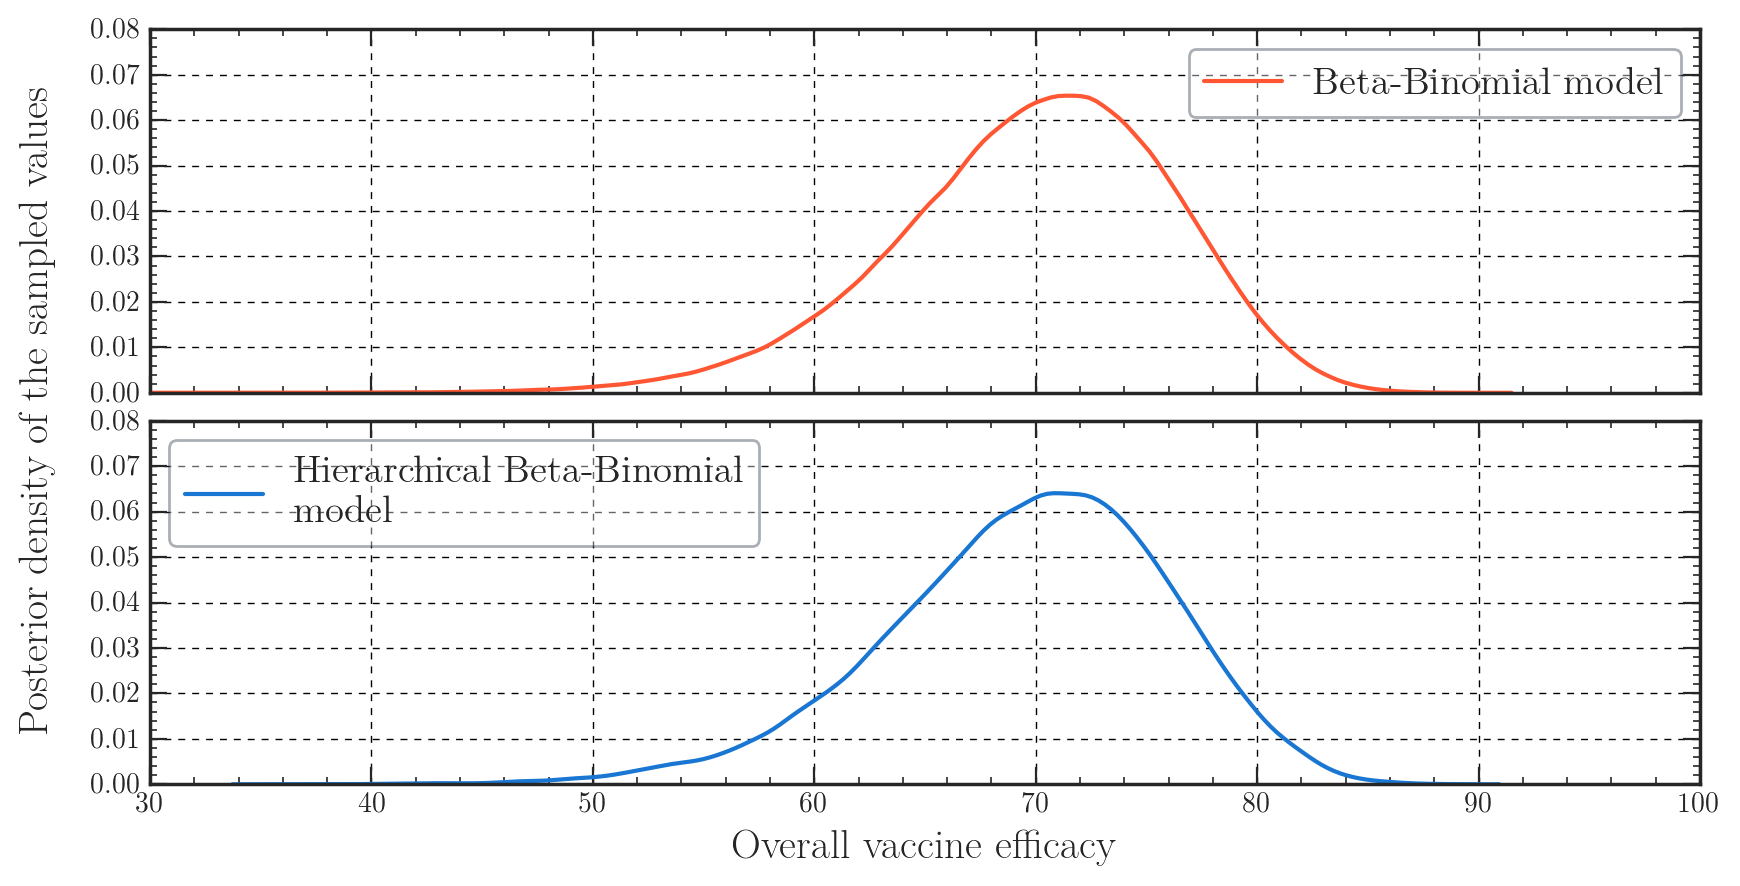

In [ ]:
fig = plt.figure(2, figsize=(10, 5))
gs = gridspec.GridSpec(12, 12)
gs.update(wspace=0.2, hspace=0.75)
# plt.axes(frameon=True)

# beta-binomial
xtr_subsplot= fig.add_subplot(gs[0:6,0:12])
sns.kdeplot(ve_samples_bb, color="#FF5733", label=" Beta-Binomial model", lw=1.5)
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=False, labeltop=False, 
                labelright=False, labelleft=True)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 30; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ", fontsize=18)

# hierarchical beta-binomial
xtr_subsplot= fig.add_subplot(gs[6:12,0:12])
sns.kdeplot(100*ve_samples_hbb, color="#1976D2", label=" Hierarchical Beta-Binomial \n model", lw=1.5)
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=True, labeltop=False, 
                labelright=False, labelleft=True)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 30; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ", fontsize=18)


plt.xlabel("Overall vaccine efficacy %", fontsize=15)
# plt.ylabel("Posterior density of the sampled values", fontsize=22)
fig.text(0.06, 0.5, 'Posterior density of the sampled values', va='center', rotation='vertical', fontsize=15)
plt.tight_layout()
plt.savefig("graph1:ovr_bb_vs_hbb", dpi=800, bbox_inches='tight')
plt.show();

# Graph 2: beta binomial comparison among algorithms for ovr

In [ ]:
n_v = 5807
n_c = 5829
x_v = 30
x_c = 101
prob = 0.958

In [ ]:
betabinom = pm.Model()

with betabinom:
    v_irr = pm.Beta("v_irr", alpha=0.020408, beta=1)
    c_irr = pm.Beta("c_irr", alpha=0.020408, beta=1)

    v_like = pm.Binomial("v_like", n=n_v, p=v_irr, observed=x_v)
    c_like = pm.Binomial("c_like", n=n_c, p=c_irr, observed=x_c)

    ve = pm.Deterministic("ve", (1-(v_irr/c_irr)))

    trace = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.HamiltonianMC())
    display(az.summary(trace, hdi_prob=prob))

    ve_samp_hmc = trace['ve'][20000:]
    print(f"VE: {100*ve_samp_hmc.mean():.2f} +- {100*ve_samp_hmc.std():.2f}")
    print(f"95% CI: {mquantiles(100*ve_samp_hmc, prob=[(1-prob)/2, (1+prob)/2])}")

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [c_irr, v_irr]


Sampling 4 chains for 6_000 tune and 25_000 draw iterations (24_000 + 100_000 draws total) took 71 seconds.
The acceptance probability does not match the target. It is 0.5324324850226088, but should be close to 0.65. Try to increase the number of tuning steps.


,mean,sd,hdi_2.1%,hdi_97.9%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_irr,0.005,0.001,0.003,0.007,0.0,0.0,56459.0,54823.0,1.0
c_irr,0.017,0.002,0.014,0.021,0.0,0.0,54099.0,56359.0,1.0
ve,0.699,0.063,0.567,0.818,0.0,0.0,54330.0,56761.0,1.0


VE: 69.91 +- 6.26
95% CI: [55.55901693 80.92831135]


In [ ]:
betabinom = pm.Model()

with betabinom:
    v_irr = pm.Beta("v_irr", alpha=0.020408, beta=1)
    c_irr = pm.Beta("c_irr", alpha=0.020408, beta=1)

    v_like = pm.Binomial("v_like", n=n_v, p=v_irr, observed=x_v)
    c_like = pm.Binomial("c_like", n=n_c, p=c_irr, observed=x_c)

    ve = pm.Deterministic("ve", (1-(v_irr/c_irr)))

    trace = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.NUTS())
    display(az.summary(trace, hdi_prob=prob))

    ve_samp_nuts = trace['ve'][20000:]
    print(f"VE: {100*ve_samp_nuts.mean():.2f} +- {100*ve_samp_nuts.std():.2f}")
    print(f"95% CI: {mquantiles(100*ve_samp_nuts, prob=[(1-prob)/2, (1+prob)/2])}")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_irr, v_irr]


Sampling 4 chains for 6_000 tune and 25_000 draw iterations (24_000 + 100_000 draws total) took 105 seconds.


,mean,sd,hdi_2.1%,hdi_97.9%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_irr,0.005,0.001,0.003,0.007,0.0,0.0,81214.0,67215.0,1.0
c_irr,0.017,0.002,0.014,0.021,0.0,0.0,75396.0,65376.0,1.0
ve,0.699,0.063,0.565,0.818,0.0,0.0,80450.0,67667.0,1.0


VE: 69.86 +- 6.31
95% CI: [55.41714997 80.97307714]


In [ ]:
N = 1000000

v_samples_0 = stats.beta.rvs(0.020408+30, 1+5807-30, size=N)
c_samples_0 = stats.beta.rvs(0.020408+101, 1+5829-101, size=N)
ve_samples_bb = 100*(1-(v_samples_0/c_samples_0))

print(f"VE: {ve_samples_0.mean():.2f} +- {ve_samples_0.std():.2f}")
print(f"95% CI: {mquantiles(ve_samples_0, prob=[0.021, 0.979])}")

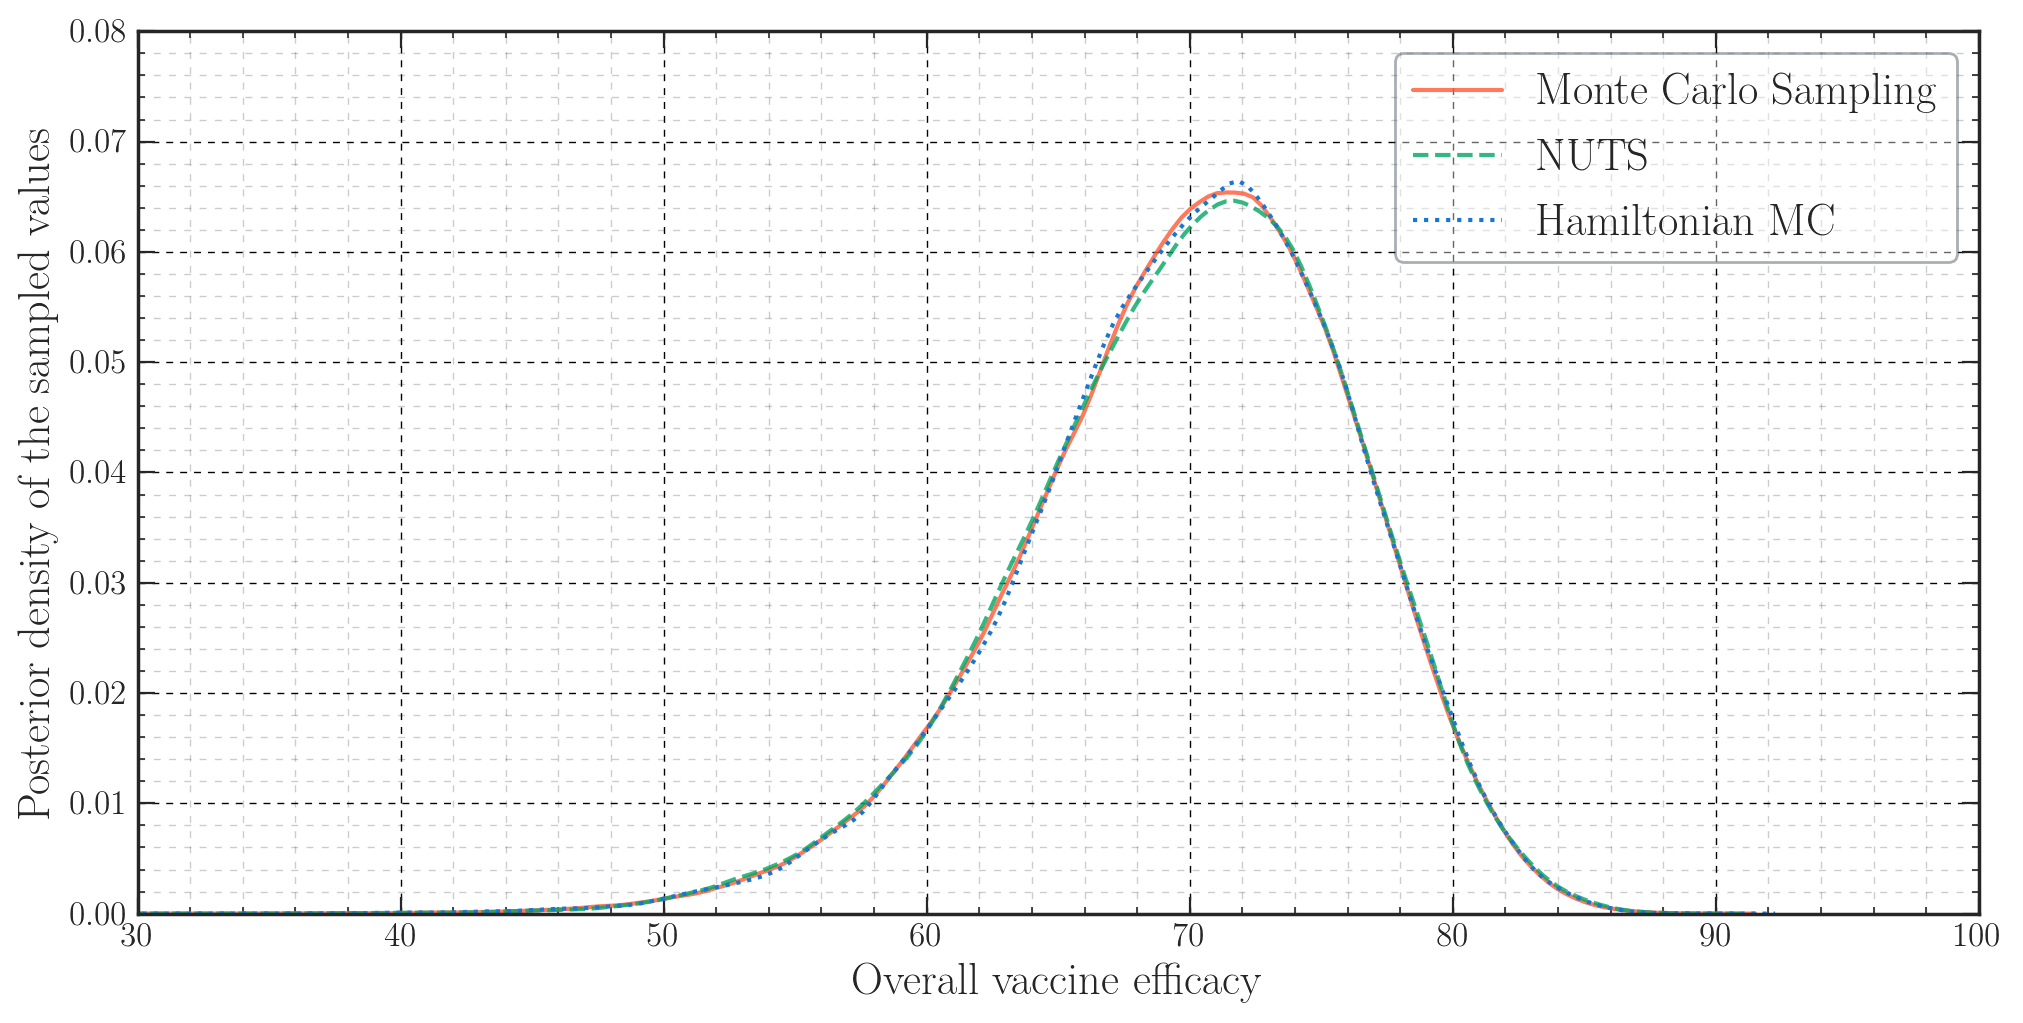

In [ ]:
fig = plt.figure(1, figsize=(10, 5))
plt.axes(frameon=True)

# plotting the data
sns.kdeplot(ve_samples_bb, color="#FF5733", label="Monte Carlo Sampling", lw=1.5, alpha=0.8)
sns.kdeplot(100*ve_samp_nuts, color="#00A662", label="NUTS", lw=1.5, ls='--', alpha=0.8)
sns.kdeplot(100*ve_samp_hmc, color="#1976D2", label="Hamiltonian MC", lw=1.5, ls=':', alpha=1)

# ticks
max = 5
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)

plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=12)
plt.xticks(rotation=0)
plt.xticks(xticks)
plt.yticks(yticks)

# limits
xmin = 30; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# grid
plt.grid(b=True, which='major', color='k', alpha=1,
        ls=(0, (5, 5)), lw=0.5)
plt.grid(b=True, which='minor', color='k', alpha=0.2,
        ls=(0, (5, 6)), lw=0.5)

# labels and titles
plt.xlabel("Overall vaccine efficacy %", fontsize=16)
plt.ylabel("Posterior density of the sampled values", fontsize=16)

# legend
plt.legend(frameon=True, fontsize=16, framealpha=0.4, edgecolor="#283747")

plt.savefig("graph2:ovr_bb_mc_nuts_hmc", dpi=800)
plt.show();

# Graph 3: hier beta binomial comparison among algorithms for ovr

In [ ]:
n_v = 5807
n_c = 5829
x_v = 30
x_c = 101
prob = 0.958

betabinom = pm.Model()

with betabinom:
    mu = pm.Uniform("mu", lower=0, upper=0.4)
    logeta = pm.Logistic("logeta", mu=np.log(1), s=1)
    eta = pm.Deterministic("eta", tt.exp(logeta))
    # eta = pm.Exponential("eta", lam=0.05)

    alpha = pm.Deterministic("alpha", eta*mu)
    beta = pm.Deterministic("beta", eta*(1-mu))

    theta_v = pm.Beta("theta_v", alpha=alpha, beta=beta)
    theta_c = pm.Beta("theta_c", alpha=alpha, beta=beta)

    X_v = pm.Binomial("X_v", n=n_v, p=theta_v, observed=x_v)
    X_c = pm.Binomial("X_c", n=n_c, p=theta_c, observed=x_c)

    ve = pm.Deterministic("ve", (1-(theta_v/theta_c)))

    hier_trace_ovr = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.NUTS())
    display(az.summary(hier_trace_ovr, hdi_prob=prob))
    # display(az.plot_trace(hier_trace_ovr))

    ve_samples_hbb = hier_trace_ovr['ve'][20000:]
    print(f"VE: {100*ve_samples_hbb.mean():.2f} +- {100*ve_samples_hbb.std():.2f}")
    print(f"95% CI: {mquantiles(100*ve_samples_hbb, prob=[(1-prob)/2, (1+prob)/2])}")

In [ ]:
n_v = 5807
n_c = 5829
x_v = 30
x_c = 101
prob = 0.958

betabinom = pm.Model()

with betabinom:
    mu = pm.Uniform("mu", lower=0, upper=0.4)
    logeta = pm.Logistic("logeta", mu=np.log(1), s=1)
    eta = pm.Deterministic("eta", tt.exp(logeta))
    # eta = pm.Exponential("eta", lam=0.05)

    alpha = pm.Deterministic("alpha", eta*mu)
    beta = pm.Deterministic("beta", eta*(1-mu))

    theta_v = pm.Beta("theta_v", alpha=alpha, beta=beta)
    theta_c = pm.Beta("theta_c", alpha=alpha, beta=beta)

    X_v = pm.Binomial("X_v", n=n_v, p=theta_v, observed=x_v)
    X_c = pm.Binomial("X_c", n=n_c, p=theta_c, observed=x_c)

    ve = pm.Deterministic("ve", (1-(theta_v/theta_c)))

    hier_trace_ovr = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.HamiltonianMC())
    display(az.summary(hier_trace_ovr, hdi_prob=prob))
    # display(az.plot_trace(hier_trace_ovr))

    ve_samples_hbb_hmc = hier_trace_ovr['ve'][20000:]
    print(f"VE: {100*ve_samples_hbb_hmc.mean():.2f} +- {100*ve_samples_hbb_hmc.std():.2f}")
    print(f"95% CI: {mquantiles(100*ve_samples_hbb_hmc, prob=[(1-prob)/2, (1+prob)/2])}")

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [theta_c, theta_v, logeta, mu]


Sampling 4 chains for 6_000 tune and 25_000 draw iterations (24_000 + 100_000 draws total) took 120 seconds.
There were 246 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5431747804365162, but should be close to 0.65. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7709339893022249, but should be close to 0.65. Try to increase the number of tuning steps.
There were 351 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45962850504235697, but should be close to 0.65. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_2.1%,hdi_97.9%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logeta,0.859,1.340,-1.541,3.985,0.013,0.012,14427.0,8304.0,1.0
mu,0.154,0.104,0.008,0.364,0.001,0.000,17668.0,9234.0,1.0
eta,8.186,29.030,0.009,35.647,0.480,0.340,14427.0,8304.0,1.0
alpha,0.389,0.457,0.011,1.126,0.007,0.006,17413.0,10104.0,1.0
beta,7.797,28.658,0.008,34.557,0.474,0.335,14427.0,8263.0,1.0
theta_v,0.005,0.001,0.003,0.007,0.000,0.000,39987.0,39484.0,1.0
theta_c,0.017,0.002,0.014,0.021,0.000,0.000,41147.0,37261.0,1.0
ve,0.696,0.063,0.560,0.813,0.000,0.000,38580.0,34355.0,1.0


VE: 69.61 +- 6.33
95% CI: [55.04683807 80.7099491 ]


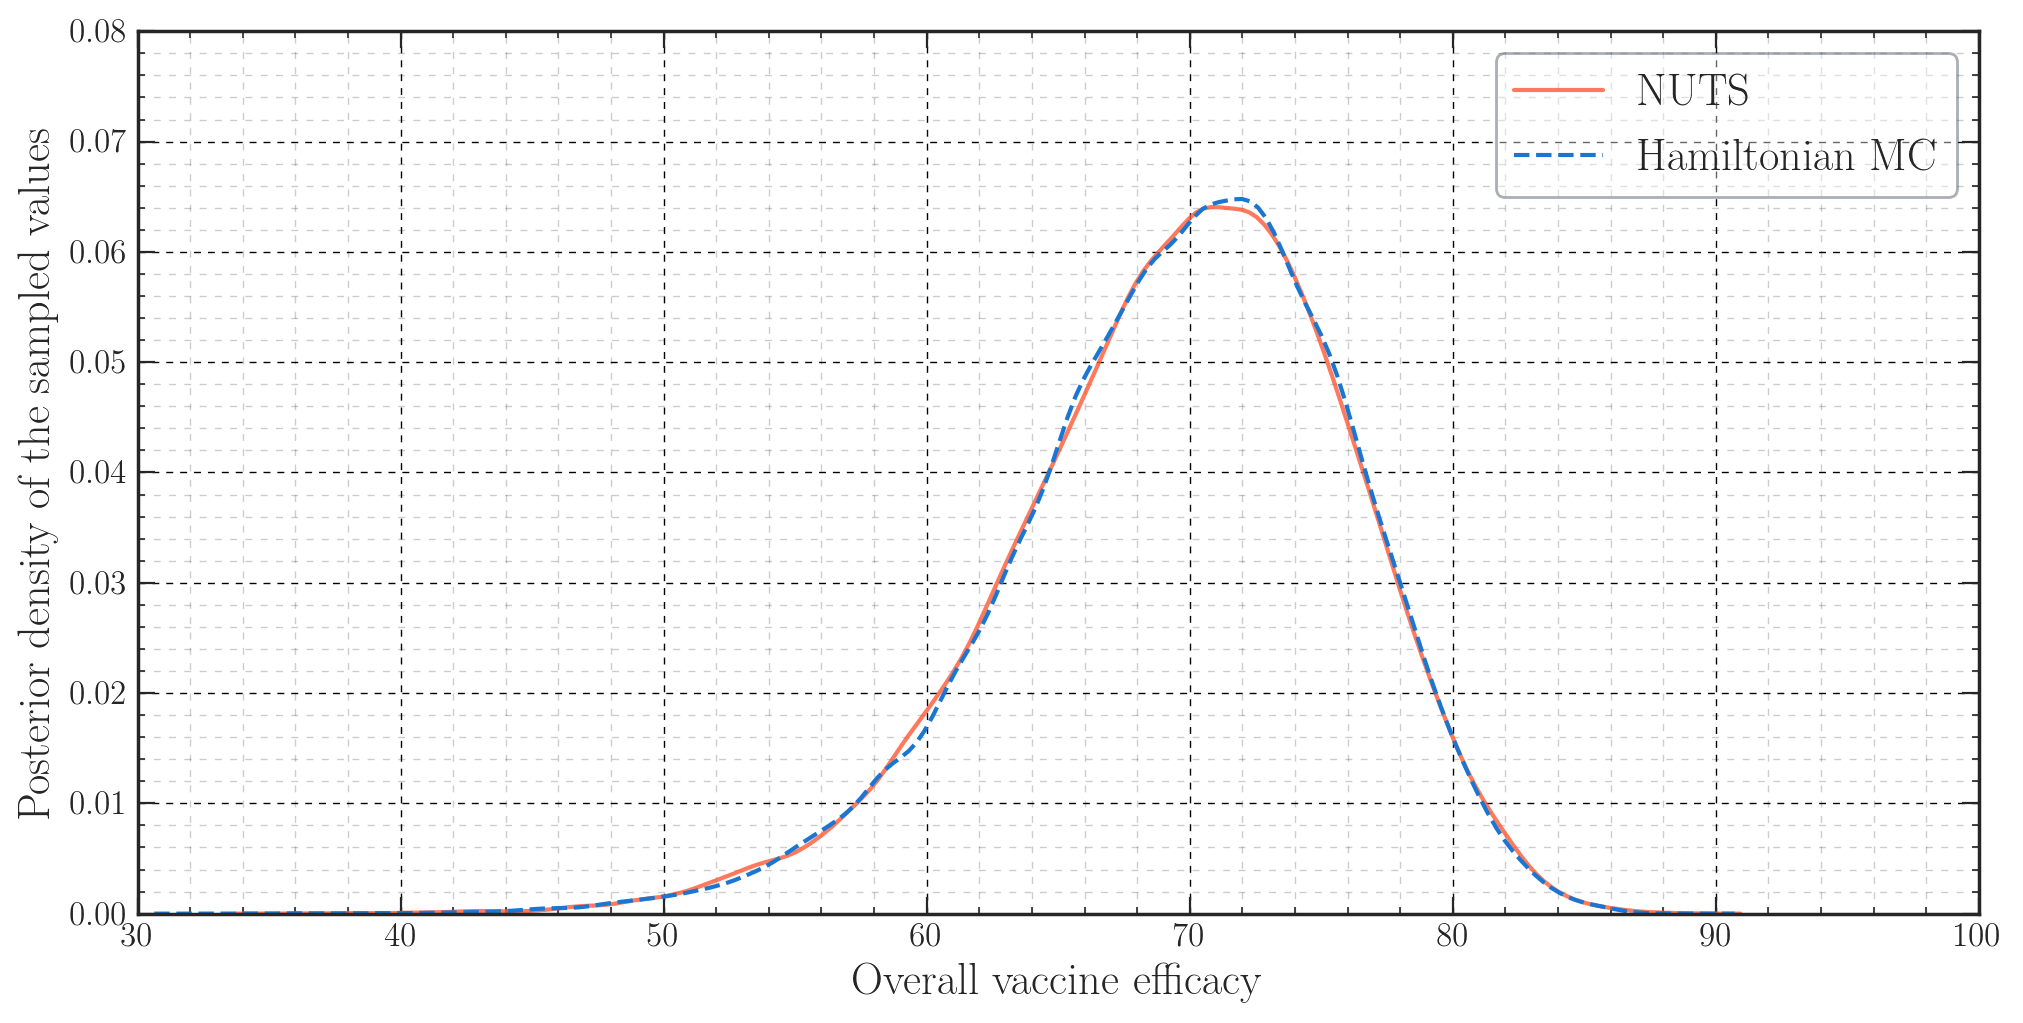

In [ ]:
fig = plt.figure(1, figsize=(10, 5))
plt.axes(frameon=True)

# plotting the data
sns.kdeplot(100*ve_samples_hbb, color="#FF5733", label="NUTS", lw=1.5, alpha=0.8)
sns.kdeplot(100*ve_samples_hbb_hmc, color="#1976D2", label="Hamiltonian MC", lw=1.5, ls='--', alpha=1)

# ticks
max = 5
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)

plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=12)
plt.xticks(rotation=0)
plt.xticks(xticks)
plt.yticks(yticks)

# limits
xmin = 30; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# grid
plt.grid(b=True, which='major', color='k', alpha=1,
        ls=(0, (5, 5)), lw=0.5)
plt.grid(b=True, which='minor', color='k', alpha=0.2,
        ls=(0, (5, 6)), lw=0.5)

# labels and titles
plt.xlabel("Overall vaccine efficacy %", fontsize=16)
plt.ylabel("Posterior density of the sampled values", fontsize=16)

# legend
plt.legend(frameon=True, fontsize=16, framealpha=0.4, edgecolor="#283747")

plt.savefig("graph3:ovr_hbb_nuts_hmc", dpi=800)
plt.show();

# Graph 4: VE comparison ovr, ldsd, sdsd across both models, NUTS

overall

In [ ]:
n_v = 5807
n_c = 5829
x_v = 30
x_c = 101
prob = 0.958

betabinom = pm.Model()

with betabinom:
    mu = pm.Uniform("mu", lower=0, upper=0.4)
    logeta = pm.Logistic("logeta", mu=np.log(1), s=1)
    eta = pm.Deterministic("eta", tt.exp(logeta))
    # eta = pm.Exponential("eta", lam=0.05)

    alpha = pm.Deterministic("alpha", eta*mu)
    beta = pm.Deterministic("beta", eta*(1-mu))

    theta_v = pm.Beta("theta_v", alpha=alpha, beta=beta)
    theta_c = pm.Beta("theta_c", alpha=alpha, beta=beta)

    X_v = pm.Binomial("X_v", n=n_v, p=theta_v, observed=x_v)
    X_c = pm.Binomial("X_c", n=n_c, p=theta_c, observed=x_c)

    ve = pm.Deterministic("ve", (1-(theta_v/theta_c)))

    hier_trace_ovr = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.NUTS())
    display(az.summary(hier_trace_ovr, hdi_prob=prob))
    # display(az.plot_trace(hier_trace_ovr))

    ovr_samples_hbb = hier_trace_ovr['ve'][20000:]
    print(f"VE: {100*ovr_samples_hbb.mean():.2f} +- {100*ovr_samples_hbb.std():.2f}")
    print(f"95% CI: {mquantiles(100*ovr_samples_hbb, prob=[(1-prob)/2, (1+prob)/2])}")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_c, theta_v, logeta, mu]


ValueError: ignored

In [ ]:
n_v = 5807
n_c = 5829
x_v = 30
x_c = 101
prob = 0.958

betabinom = pm.Model()

with betabinom:
    v_irr = pm.Beta("v_irr", alpha=0.020408, beta=1)
    c_irr = pm.Beta("c_irr", alpha=0.020408, beta=1)

    v_like = pm.Binomial("v_like", n=n_v, p=v_irr, observed=x_v)
    c_like = pm.Binomial("c_like", n=n_c, p=c_irr, observed=x_c)

    ve = pm.Deterministic("ve", (1-(v_irr/c_irr)))

    trace = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.NUTS())
    display(az.summary(trace, hdi_prob=prob))

    ovr_samples_bb = trace['ve'][20000:]
    print(f"VE: {100*ovr_samples_bb.mean():.2f} +- {100*ovr_samples_bb.std():.2f}")
    print(f"95% CI: {mquantiles(100*ovr_samples_bb, prob=[(1-prob)/2, (1+prob)/2])}")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_irr, v_irr]


Sampling 4 chains for 6_000 tune and 25_000 draw iterations (24_000 + 100_000 draws total) took 120 seconds.


,mean,sd,hdi_2.1%,hdi_97.9%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_irr,0.005,0.001,0.003,0.007,0.0,0.0,80075.0,66057.0,1.0
c_irr,0.017,0.002,0.014,0.021,0.0,0.0,72119.0,63015.0,1.0
ve,0.699,0.063,0.567,0.818,0.0,0.0,78210.0,70867.0,1.0


VE: 69.87 +- 6.29
95% CI: [55.462457   81.00343095]


ldsd

In [ ]:
# ldsd
n_v = 1367
n_c = 1374
x_v = 3
x_c = 30
prob = 0.95

betabinom = pm.Model()

with betabinom:
    mu = pm.Uniform("mu", lower=0, upper=0.4)
    logeta = pm.Logistic("logeta", mu=np.log(1), s=1)
    eta = pm.Deterministic("eta", tt.exp(logeta))
    # eta = pm.Exponential("eta", lam=0.05)

    alpha = pm.Deterministic("alpha", eta*mu)
    beta = pm.Deterministic("beta", eta*(1-mu))

    theta_v = pm.Beta("theta_v", alpha=alpha, beta=beta)
    theta_c = pm.Beta("theta_c", alpha=alpha, beta=beta)

    X_v = pm.Binomial("X_v", n=n_v, p=theta_v, observed=x_v)
    X_c = pm.Binomial("X_c", n=n_c, p=theta_c, observed=x_c)

    ve = pm.Deterministic("ve", (1-(theta_v/theta_c)))

    hier_trace_ldsd = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.NUTS())
    display(az.summary(hier_trace_ldsd, hdi_prob=prob))
    # display(az.plot_trace(hier_trace_ldsd))

    ldsd_samples_hbb = hier_trace_ldsd['ve'][20000:]
    print(f"VE: {100*ldsd_samples_hbb.mean():.2f} +- {100*ldsd_samples_hbb.std():.2f}")
    print(f"95% CI: {mquantiles(100*ldsd_samples_hbb, prob=[(1-prob)/2, (1+prob)/2])}")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_c, theta_v, logeta, mu]


Sampling 4 chains for 6_000 tune and 25_000 draw iterations (24_000 + 100_000 draws total) took 228 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logeta,0.669,1.229,-1.593,3.255,0.007,0.006,36230.0,26119.0,1.0
mu,0.158,0.104,0.007,0.358,0.000,0.000,38236.0,34046.0,1.0
eta,5.203,17.156,0.012,18.527,0.141,0.109,36230.0,26119.0,1.0
alpha,0.316,0.295,0.011,0.821,0.002,0.002,63990.0,44655.0,1.0
beta,4.886,16.964,0.015,17.890,0.140,0.107,35692.0,25988.0,1.0
theta_v,0.002,0.001,0.000,0.005,0.000,0.000,52688.0,42323.0,1.0
theta_c,0.022,0.004,0.014,0.030,0.000,0.000,61790.0,56407.0,1.0
ve,0.886,0.068,0.752,0.988,0.000,0.000,52028.0,43133.0,1.0


VE: 88.58 +- 6.79
95% CI: [71.76748041 97.60866277]


In [ ]:
n_v = 1367
n_c = 1374
x_v = 3
x_c = 30
prob = 0.95

betabinom = pm.Model()

with betabinom:
    v_irr = pm.Beta("v_irr", alpha=0.020408, beta=1)
    c_irr = pm.Beta("c_irr", alpha=0.020408, beta=1)

    v_like = pm.Binomial("v_like", n=n_v, p=v_irr, observed=x_v)
    c_like = pm.Binomial("c_like", n=n_c, p=c_irr, observed=x_c)

    ve = pm.Deterministic("ve", (1-(v_irr/c_irr)))

    trace = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.NUTS())
    display(az.summary(trace, hdi_prob=prob))

    ldsd_samples_bb = trace['ve'][20000:]
    print(f"VE: {100*ldsd_samples_bb.mean():.2f} +- {100*ldsd_samples_bb.std():.2f}")
    print(f"95% CI: {mquantiles(100*ldsd_samples_bb, prob=[(1-prob)/2, (1+prob)/2])}")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_irr, v_irr]


Sampling 4 chains for 6_000 tune and 25_000 draw iterations (24_000 + 100_000 draws total) took 129 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_irr,0.002,0.001,0.000,0.005,0.0,0.0,71320.0,53813.0,1.0
c_irr,0.022,0.004,0.014,0.030,0.0,0.0,80574.0,60964.0,1.0
ve,0.895,0.065,0.770,0.990,0.0,0.0,72109.0,54919.0,1.0


VE: 89.44 +- 6.52
95% CI: [73.37049234 97.89461853]


sdsd

In [ ]:
# sdsd
n_v = 4440
n_c = 4455
x_v = 27
x_c = 71
prob = 0.95

betabinom = pm.Model()

with betabinom:
    mu = pm.Uniform("mu", lower=0, upper=0.4)
    logeta = pm.Logistic("logeta", mu=np.log(1), s=1)
    eta = pm.Deterministic("eta", tt.exp(logeta))
    # eta = pm.Exponential("eta", lam=0.05)

    alpha = pm.Deterministic("alpha", eta*mu)
    beta = pm.Deterministic("beta", eta*(1-mu))

    theta_v = pm.Beta("theta_v", alpha=alpha, beta=beta)
    theta_c = pm.Beta("theta_c", alpha=alpha, beta=beta)

    X_v = pm.Binomial("X_v", n=n_v, p=theta_v, observed=x_v)
    X_c = pm.Binomial("X_c", n=n_c, p=theta_c, observed=x_c)

    ve = pm.Deterministic("ve", (1-(theta_v/theta_c)))

    hier_trace_sdsd = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.NUTS())
    display(az.summary(hier_trace_sdsd, hdi_prob=prob))
    # display(az.plot_trace(hier_trace_sdsd))

    sdsd_samples_hbb = hier_trace_sdsd['ve'][20000:]
    print(f"VE: {100*sdsd_samples_hbb.mean():.2f} +- {100*sdsd_samples_hbb.std():.2f}")
    print(f"95% CI: {mquantiles(100*sdsd_samples_hbb, prob=[(1-prob)/2, (1+prob)/2])}")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_c, theta_v, logeta, mu]


Sampling 4 chains for 6_000 tune and 25_000 draw iterations (24_000 + 100_000 draws total) took 233 seconds.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
There were 265 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logeta,0.911,1.392,-1.541,3.966,0.009,0.009,28323.0,16391.0,1.0
mu,0.153,0.105,0.005,0.355,0.001,0.000,31048.0,21233.0,1.0
eta,9.701,35.113,0.026,35.552,0.364,0.258,28323.0,16391.0,1.0
alpha,0.412,0.502,0.008,1.135,0.004,0.003,41175.0,23726.0,1.0
beta,9.289,34.702,0.018,34.654,0.361,0.255,28028.0,16312.0,1.0
theta_v,0.006,0.001,0.004,0.008,0.000,0.000,54793.0,49792.0,1.0
theta_c,0.016,0.002,0.012,0.020,0.000,0.000,51647.0,48694.0,1.0
ve,0.609,0.089,0.432,0.774,0.000,0.000,53815.0,50355.0,1.0


VE: 60.94 +- 8.94
95% CI: [40.99580017 75.96160646]


In [ ]:
n_v = 4440
n_c = 4455
x_v = 27
x_c = 71
prob = 0.95

betabinom = pm.Model()

with betabinom:
    v_irr = pm.Beta("v_irr", alpha=0.020408, beta=1)
    c_irr = pm.Beta("c_irr", alpha=0.020408, beta=1)

    v_like = pm.Binomial("v_like", n=n_v, p=v_irr, observed=x_v)
    c_like = pm.Binomial("c_like", n=n_c, p=c_irr, observed=x_c)

    ve = pm.Deterministic("ve", (1-(v_irr/c_irr)))

    trace = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.NUTS())
    display(az.summary(trace, hdi_prob=prob))

    sdsd_samples_bb = trace['ve'][20000:]
    print(f"VE: {100*sdsd_samples_bb.mean():.2f} +- {100*sdsd_samples_bb.std():.2f}")
    print(f"95% CI: {mquantiles(100*sdsd_samples_bb, prob=[(1-prob)/2, (1+prob)/2])}")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_irr, v_irr]


Sampling 4 chains for 6_000 tune and 25_000 draw iterations (24_000 + 100_000 draws total) took 132 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_irr,0.006,0.001,0.004,0.008,0.0,0.0,83835.0,61876.0,1.0
c_irr,0.016,0.002,0.012,0.020,0.0,0.0,83240.0,70565.0,1.0
ve,0.612,0.089,0.436,0.774,0.0,0.0,84141.0,67778.0,1.0


VE: 61.21 +- 8.85
95% CI: [41.70514476 76.04217412]


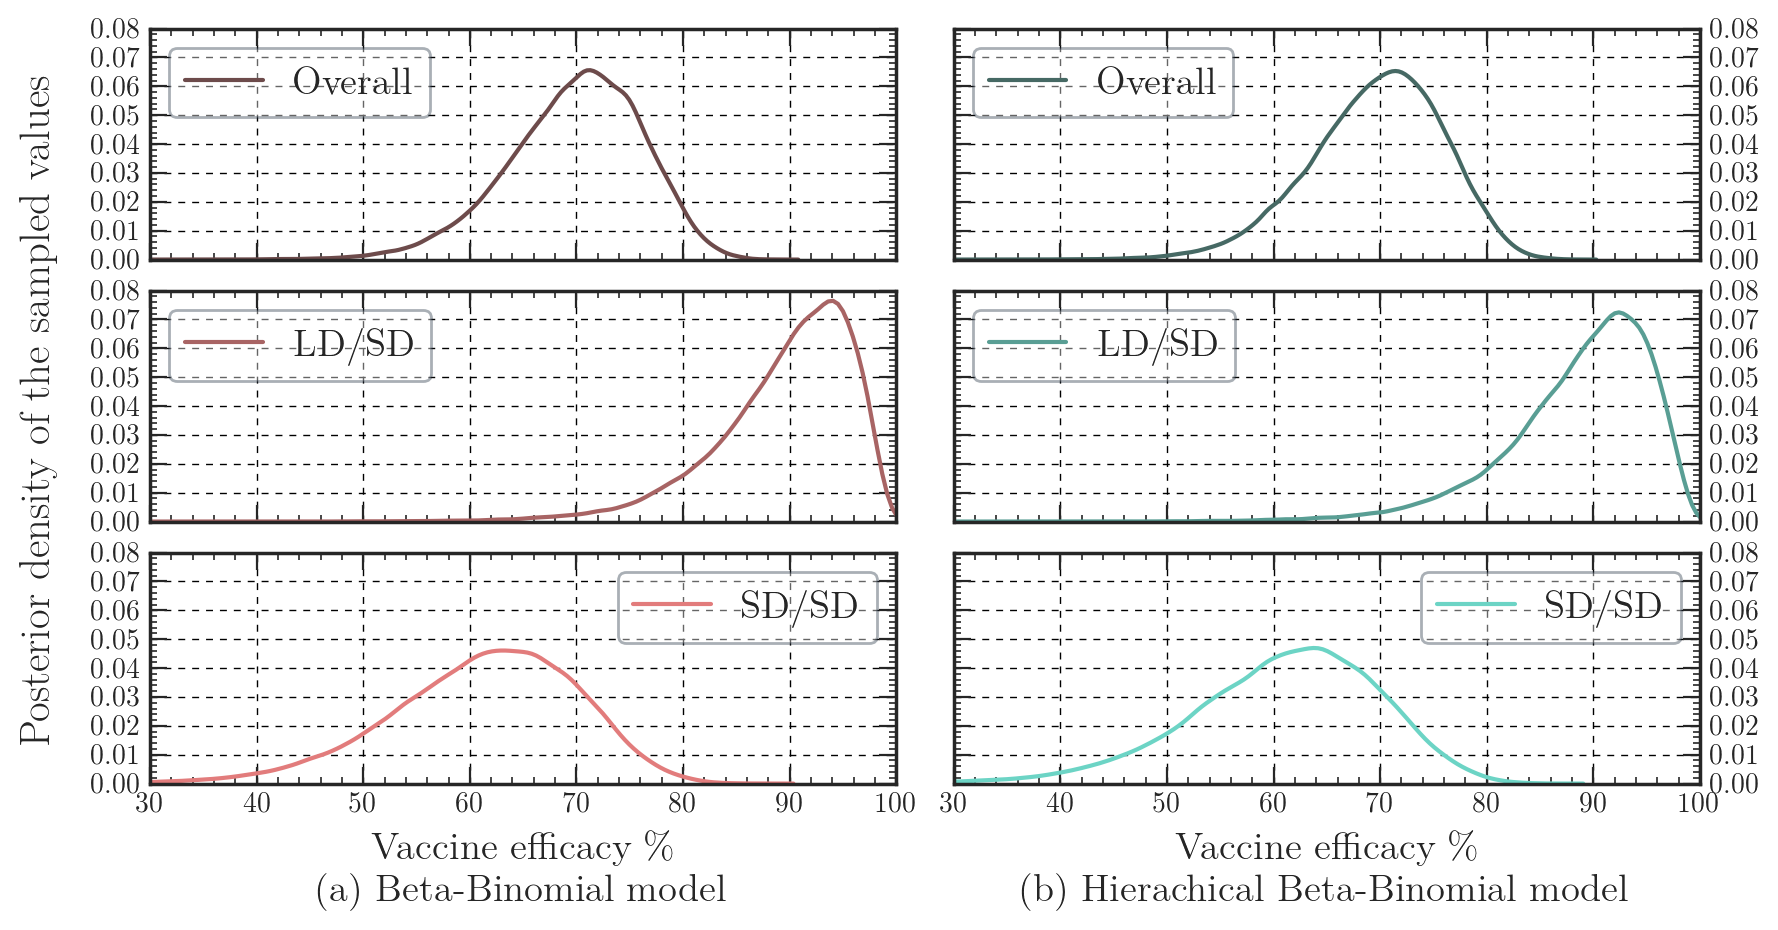

In [ ]:
fig = plt.figure(4, figsize=(10, 5))
gs = gridspec.GridSpec(12, 12)
gs.update(wspace=0.75, hspace=0.9)
# plt.axes(frameon=True)

# beta-binomial

# overall
xtr_subsplot= fig.add_subplot(gs[0:4,0:6])
sns.kdeplot(100*ovr_samples_bb, color=salmon_to_aqua[2], label=" Overall", lw=1.5)
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=False, labeltop=False, 
                labelright=False, labelleft=True)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 30; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ", fontsize=18)

# ldsd
xtr_subsplot= fig.add_subplot(gs[4:8,0:6])
sns.kdeplot(100*ldsd_samples_bb, color=salmon_to_aqua[1], label=" LD/SD", lw=1.5)
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=False, labeltop=False, 
                labelright=False, labelleft=True)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 30; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ", fontsize=18)

# sdsd
xtr_subsplot= fig.add_subplot(gs[8:12,0:6])
sns.kdeplot(100*sdsd_samples_bb, color=salmon_to_aqua[0], label=" SD/SD", lw=1.5)
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=True, labeltop=False, 
                labelright=False, labelleft=True)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 30; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ", fontsize=18)
plt.xlabel("Vaccine efficacy \% \n (a) Beta-Binomial model", fontsize=14)

# -------------------------------------------------------------------------------------------------------

# hierarchical beta binomial model

# overall
xtr_subsplot= fig.add_subplot(gs[0:4,6:12])
sns.kdeplot(100*ovr_samples_hbb, color=salmon_to_aqua[6], label=" Overall", lw=1.5)
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=False, labeltop=False, 
                labelright=True, labelleft=False)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 30; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ", fontsize=18)

# ldsd
xtr_subsplot= fig.add_subplot(gs[4:8,6:12])
sns.kdeplot(100*ldsd_samples_hbb, color=salmon_to_aqua[7], label=" LD/SD", lw=1.5)
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=False, labeltop=False, 
                labelright=True, labelleft=False)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 30; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ", fontsize=18)

# sdsd
xtr_subsplot= fig.add_subplot(gs[8:12,6:12])
sns.kdeplot(100*sdsd_samples_hbb, color=salmon_to_aqua[8], label=" SD/SD", lw=1.5)
xticks = np.arange(20, 101, 10)
yticks = np.arange(0, 0.09, 0.01)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=True, labeltop=False, 
                labelright=True, labelleft=False)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 30; xmax = 100
ymin = 0; ymax = 0.08
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ", fontsize=18)
plt.xlabel("Vaccine efficacy \% \n (b) Hierachical Beta-Binomial model", fontsize=14)




# plt.xlabel("Overall vaccine efficacy %", fontsize=15)
# plt.ylabel("Posterior density of the sampled values", fontsize=22)
fig.text(0.06, 0.5, 'Posterior density of the sampled values', va='center', rotation='vertical', fontsize=15.5)
plt.tight_layout()
plt.savefig("graph4:bb_vs_hbb_all", dpi=800, bbox_inches='tight')
plt.show();

# Graph 5: comparing overall $\theta_V$ and $\theta_C$ from the two models

In [ ]:
n_v = 5807
n_c = 5829
x_v = 30
x_c = 101
prob = 0.958

betabinom = pm.Model()

with betabinom:
    mu = pm.Uniform("mu", lower=0, upper=0.4)
    logeta = pm.Logistic("logeta", mu=np.log(1), s=1)
    eta = pm.Deterministic("eta", tt.exp(logeta))
    # eta = pm.Exponential("eta", lam=0.05)

    alpha = pm.Deterministic("alpha", eta*mu)
    beta = pm.Deterministic("beta", eta*(1-mu))

    theta_v = pm.Beta("theta_v", alpha=alpha, beta=beta)
    theta_c = pm.Beta("theta_c", alpha=alpha, beta=beta)

    X_v = pm.Binomial("X_v", n=n_v, p=theta_v, observed=x_v)
    X_c = pm.Binomial("X_c", n=n_c, p=theta_c, observed=x_c)

    ve = pm.Deterministic("ve", (1-(theta_v/theta_c)))

    hier_trace_ovr = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.NUTS())
    display(az.summary(hier_trace_ovr, hdi_prob=prob))
    # display(az.plot_trace(hier_trace_ovr))

    ovr_samples_hbb = hier_trace_ovr['ve'][20000:]
    print(f"VE: {100*ovr_samples_hbb.mean():.2f} +- {100*ovr_samples_hbb.std():.2f}")
    print(f"95% CI: {mquantiles(100*ovr_samples_hbb, prob=[(1-prob)/2, (1+prob)/2])}")

    thv_hbb = hier_trace_ovr['theta_v'][20000:]
    thc_hbb = hier_trace_ovr['theta_c'][20000:]

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_c, theta_v, logeta, mu]


Sampling 4 chains for 6_000 tune and 25_000 draw iterations (24_000 + 100_000 draws total) took 223 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 193 divergences after tuning. Increase `target_accept` or reparameterize.
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_2.1%,hdi_97.9%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logeta,0.872,1.368,-1.654,4.018,0.010,0.010,24939.0,11237.0,1.0
mu,0.154,0.105,0.005,0.362,0.001,0.000,30636.0,22048.0,1.0
eta,8.852,33.024,0.015,39.219,0.380,0.269,24939.0,11237.0,1.0
alpha,0.397,0.499,0.006,1.150,0.007,0.005,28941.0,14274.0,1.0
beta,8.455,32.617,0.012,38.253,0.374,0.264,24871.0,11218.0,1.0
theta_v,0.005,0.001,0.003,0.007,0.000,0.000,56888.0,54482.0,1.0
theta_c,0.017,0.002,0.014,0.021,0.000,0.000,59069.0,55054.0,1.0
ve,0.696,0.063,0.566,0.815,0.000,0.000,55482.0,54840.0,1.0


VE: 69.62 +- 6.27
95% CI: [55.42339809 80.66189645]


In [ ]:
n_v = 5807
n_c = 5829
x_v = 30
x_c = 101
prob = 0.958

betabinom = pm.Model()

with betabinom:
    v_irr = pm.Beta("v_irr", alpha=0.020408, beta=1)
    c_irr = pm.Beta("c_irr", alpha=0.020408, beta=1)

    v_like = pm.Binomial("v_like", n=n_v, p=v_irr, observed=x_v)
    c_like = pm.Binomial("c_like", n=n_c, p=c_irr, observed=x_c)

    ve = pm.Deterministic("ve", (1-(v_irr/c_irr)))

    trace = pm.sample(draws=25000, tune=6000, cores=4, return_inferencedata=False, step=pm.NUTS())
    display(az.summary(trace, hdi_prob=prob))

    ovr_samples_bb = trace['ve'][20000:]
    print(f"VE: {100*ovr_samples_bb.mean():.2f} +- {100*ovr_samples_bb.std():.2f}")
    print(f"95% CI: {mquantiles(100*ovr_samples_bb, prob=[(1-prob)/2, (1+prob)/2])}")

    thv_bb = trace['v_irr'][20000:]
    thc_bb = trace['c_irr'][20000:]

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_irr, v_irr]


Sampling 4 chains for 6_000 tune and 25_000 draw iterations (24_000 + 100_000 draws total) took 124 seconds.


,mean,sd,hdi_2.1%,hdi_97.9%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_irr,0.005,0.001,0.003,0.007,0.0,0.0,90061.0,69250.0,1.0
c_irr,0.017,0.002,0.014,0.021,0.0,0.0,87296.0,70002.0,1.0
ve,0.699,0.063,0.566,0.817,0.0,0.0,88684.0,69403.0,1.0


VE: 69.85 +- 6.33
95% CI: [55.41897043 80.93735983]


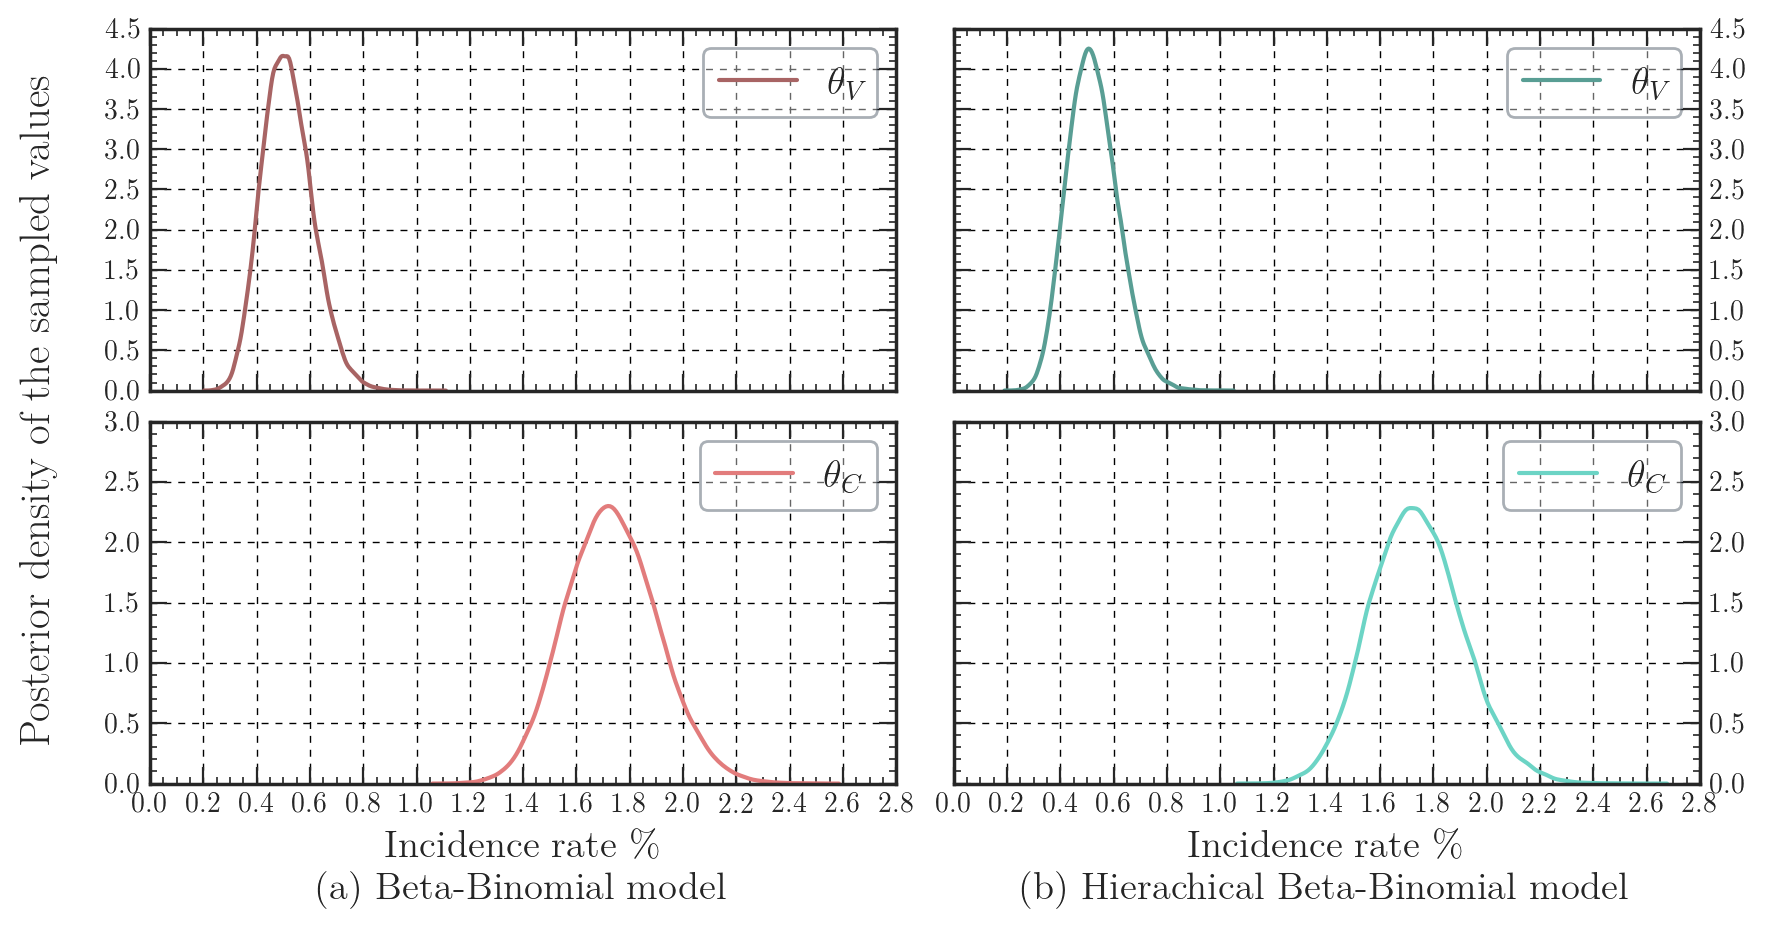

In [ ]:
fig = plt.figure(4, figsize=(10, 5))
gs = gridspec.GridSpec(12, 12)
gs.update(wspace=0.75, hspace=0.9)
# plt.axes(frameon=True)

# beta-binomial

# theta_v
xtr_subsplot= fig.add_subplot(gs[0:6,0:6])
sns.kdeplot(100*thv_bb, color=salmon_to_aqua[1], label=" $\\theta_V$", lw=1.5)
xticks = np.arange(0, 3, 0.2)
yticks = np.arange(0, 5, 0.5)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=False, labeltop=False, 
                labelright=False, labelleft=True)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 0; xmax = 2.8
ymin = 0; ymax = 4.5
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ", fontsize=18)

# theta_c
xtr_subsplot= fig.add_subplot(gs[6:12,0:6])
sns.kdeplot(100*thc_bb, color=salmon_to_aqua[0], label=" $\\theta_C$", lw=1.5)
xticks = np.arange(0, 3, 0.2)
yticks = np.arange(0, 3.5, 0.5)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=True, labeltop=False, 
                labelright=False, labelleft=True)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 0; xmax = 2.8
ymin = 0; ymax = 3
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ", fontsize=18)
plt.xlabel("Incidence rate \% \n (a) Beta-Binomial model", fontsize=14)

# -------------------------------------------------------------------------------------------------------

# hierarchical beta binomial model

# theta_v
xtr_subsplot= fig.add_subplot(gs[0:6,6:12])
sns.kdeplot(100*thv_hbb, color=salmon_to_aqua[7], label=" $\\theta_V$", lw=1.5)
xticks = np.arange(0, 3, 0.2)
yticks = np.arange(0, 5, 0.5)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=False, labeltop=False, 
                labelright=True, labelleft=False)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 0; xmax = 2.8
ymin = 0; ymax = 4.5
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ", fontsize=18)

# theta_c
xtr_subsplot= fig.add_subplot(gs[6:12,6:12])
sns.kdeplot(100*thc_hbb, color=salmon_to_aqua[8], label=" $\\theta_C$", lw=1.5)
xticks = np.arange(0, 3, 0.2)
yticks = np.arange(0, 3.5, 0.5)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=2.5, 
                bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=6, 
                bottom=True, top=True, left=True, right=True, labelsize=10)
plt.tick_params(labelbottom=True, labeltop=False, 
                labelright=True, labelleft=False)
plt.xticks(xticks)
plt.yticks(yticks)
xmin = 0; xmax = 2.8
ymin = 0; ymax = 3
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(b=True, which='major', color='k', alpha=1, ls=(0, (5, 5)), lw=0.5)
# plt.grid(b=True, which='minor', color='k', alpha=0.2, ls=(0, (5, 6)), lw=0.5)
plt.legend(frameon=True, fontsize=14, framealpha=0.4, edgecolor="#283747")
plt.ylabel(" ", fontsize=18)
plt.xlabel("Incidence rate \% \n (b) Hierachical Beta-Binomial model", fontsize=14)




# plt.xlabel("Overall vaccine efficacy %", fontsize=15)
# plt.ylabel("Posterior density of the sampled values", fontsize=22)
fig.text(0.06, 0.5, 'Posterior density of the sampled values', va='center', rotation='vertical', fontsize=15.5)
plt.tight_layout()
plt.savefig("graph5:theta_v_vs_theta_c", dpi=800, bbox_inches='tight')
plt.show();

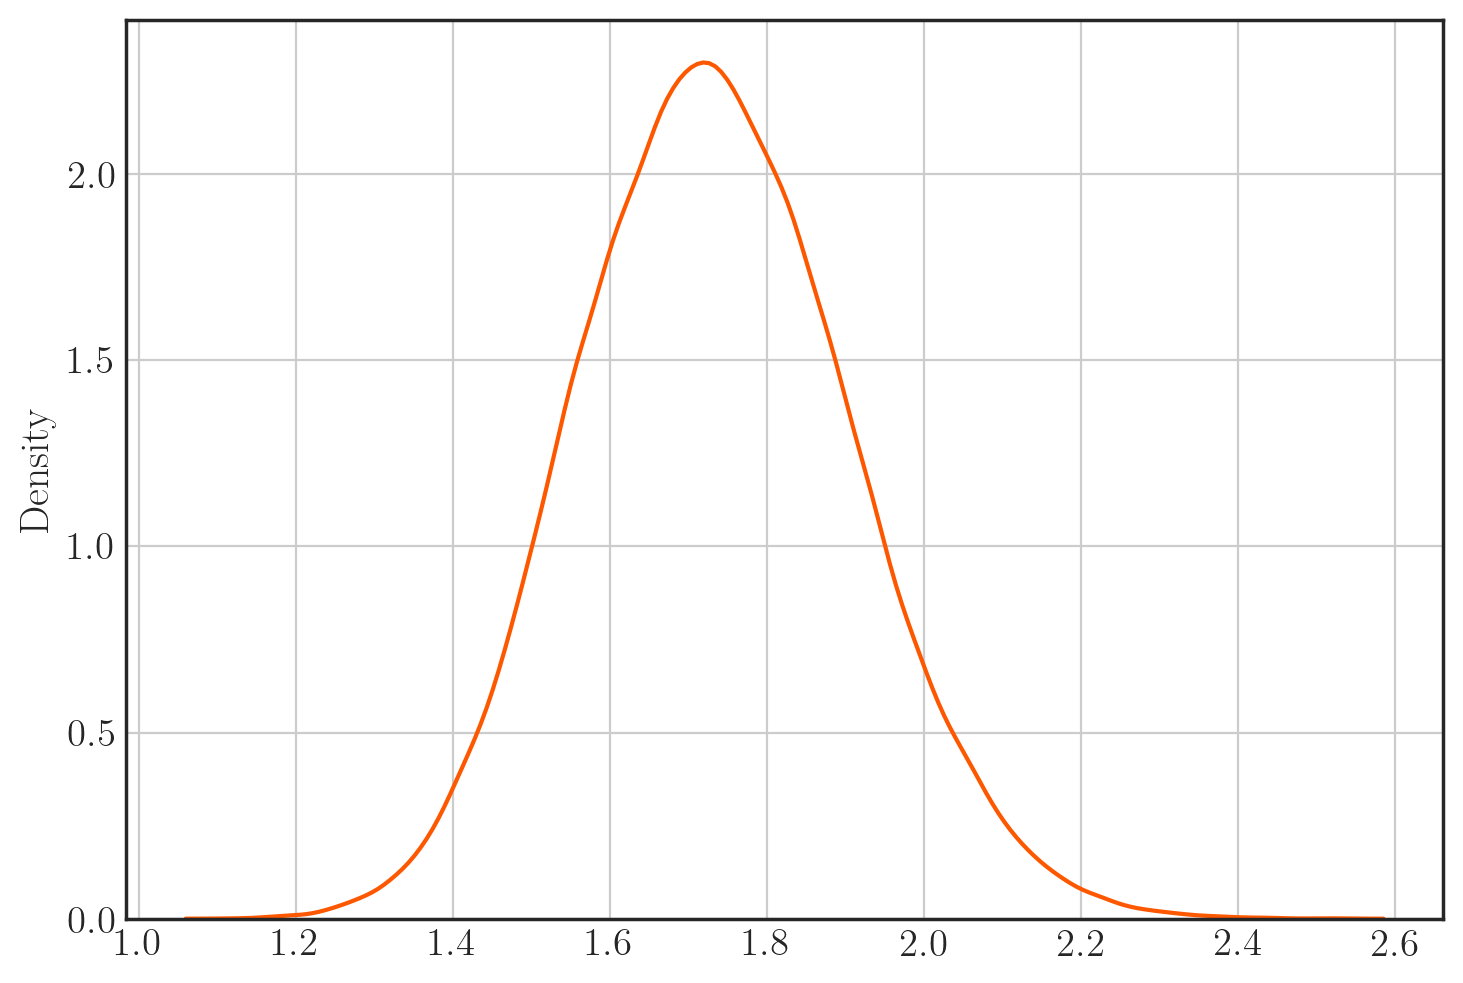

In [ ]:
sns.kdeplot(100*thc_bb)

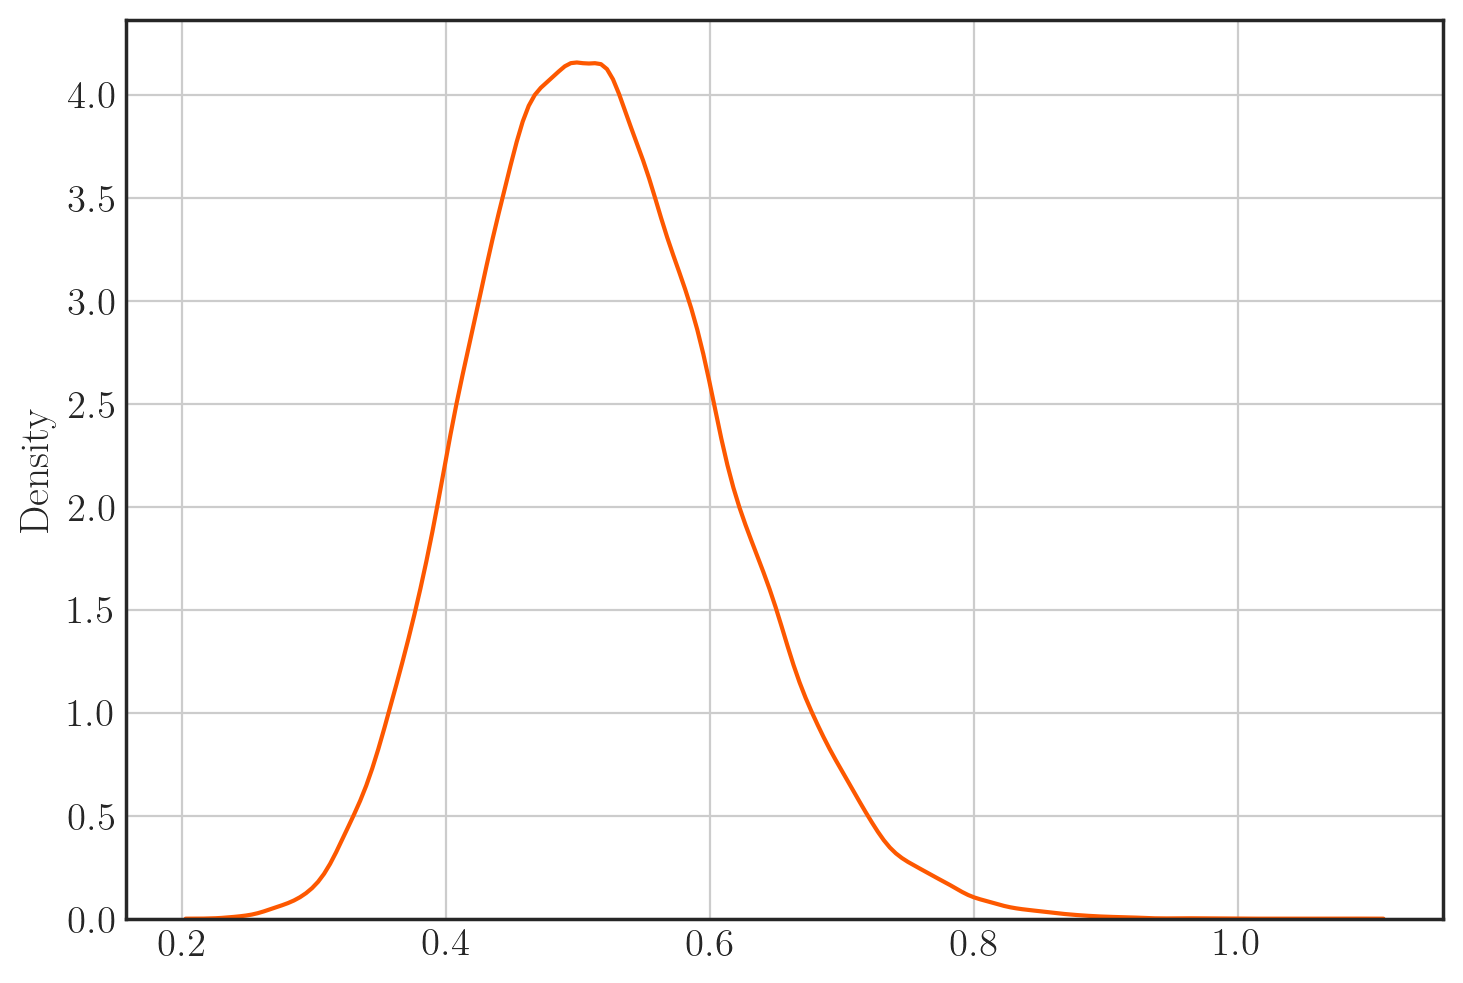

In [ ]:
sns.kdeplot(100*thv_bb)

# others

In [ ]:
f = open("ve_samples_bb.txt", "w")
for element in ve_samples_bb:
    f.write(str(element)+"\n")

In [ ]:
f = open("ve_samples_hbb.txt", "w")
for element in ve_samples_hbb:
    f.write(str(element)+"\n")

In [ ]:
f = open("ve_samp_nuts.txt", "w")
for element in ve_samp_nuts:
    f.write(str(element)+"\n")

In [ ]:
f = open("ve_samp_hmc.txt", "w")
for element in ve_samp_hmc:
    f.write(str(element)+"\n")